<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="700" height="200" />


### <font color='navy'> Modelos no lineales para pronósticos.

**Nombres:**
- Zamarrón Álvarez, Ana Rosaura
- Castillejos Jauregui, Claudia Celeste

**Fecha:** 24 de abril del 2023.

**Expediente** :
- 736222
- 735868

**Profesor:** Oscar David Jaramillo Zuluaga.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import MSTL
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Cargamos los datos
data = pd.read_csv("traffic.csv")
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [3]:
# El tamaño del arreglo 
data.shape

(48120, 4)

In [4]:
#Ver el tipo de dato de las variables
data.dtypes

DateTime    object
Junction     int64
Vehicles     int64
ID           int64
dtype: object

In [5]:
# Cambiar el tipo de dato de las variables necesarias
data["ID"] = data["ID"].astype("object")
data["DateTime"] = pd.to_datetime(data['DateTime'])

In [6]:
# Ver el resultado del cambio en el tipo de variable 
data.dtypes

DateTime    datetime64[ns]
Junction             int64
Vehicles             int64
ID                  object
dtype: object

In [7]:
# Descripción de las variables numéricas
data.describe()

,Junction,Vehicles
count,48120.000000,48120.000000
mean,2.180549,22.791334
std,0.966955,20.750063
min,1.000000,1.000000
25%,1.000000,9.000000
50%,2.000000,15.000000
75%,3.000000,29.000000
max,4.000000,180.000000


In [8]:
# Vemos los valores de la columna date+time
data["DateTime"].value_counts()

2017-06-30 23:00:00    4
2017-03-02 02:00:00    4
2017-03-02 16:00:00    4
2017-03-02 15:00:00    4
2017-03-02 14:00:00    4
                      ..
2016-05-21 19:00:00    3
2016-05-21 20:00:00    3
2016-05-21 21:00:00    3
2016-05-21 22:00:00    3
2016-08-31 00:00:00    3
Name: DateTime, Length: 14592, dtype: int64

In [9]:
# Ver los registros con esa fecha
data[data["DateTime"] == "2017-06-30 23:00:00"]

,DateTime,Junction,Vehicles,ID
14591,2017-06-30 23:00:00,1,78,20170630231
29183,2017-06-30 23:00:00,2,27,20170630232
43775,2017-06-30 23:00:00,3,39,20170630233
48119,2017-06-30 23:00:00,4,12,20170630234


In [10]:
# Ver los registros con esa fecha
data[data["DateTime"] == "2017-03-02 02:00:00"]

,DateTime,Junction,Vehicles,ID
11690,2017-03-02 02:00:00,1,50,20170302021
26282,2017-03-02 02:00:00,2,24,20170302022
40874,2017-03-02 02:00:00,3,11,20170302023
45218,2017-03-02 02:00:00,4,5,20170302024


Las fechas se repiten para cada junction. Nos quedaremos con una sola serie , la de Junction 1.

In [11]:
# Reducimos la base de datos
junction1 = data[data["Junction"] == 1]
junction1.shape

(14592, 4)

In [12]:
#Hacemos una reducción de la base de datos
timeseries = junction1[["DateTime", "Vehicles"]].set_index('DateTime')
timeseries.head()

,Vehicles
DateTime,
2015-11-01 00:00:00,15
2015-11-01 01:00:00,13
2015-11-01 02:00:00,10
2015-11-01 03:00:00,7
2015-11-01 04:00:00,9


Text(0.5, 1.0, 'Junction 1 Vehicles Timeserie')

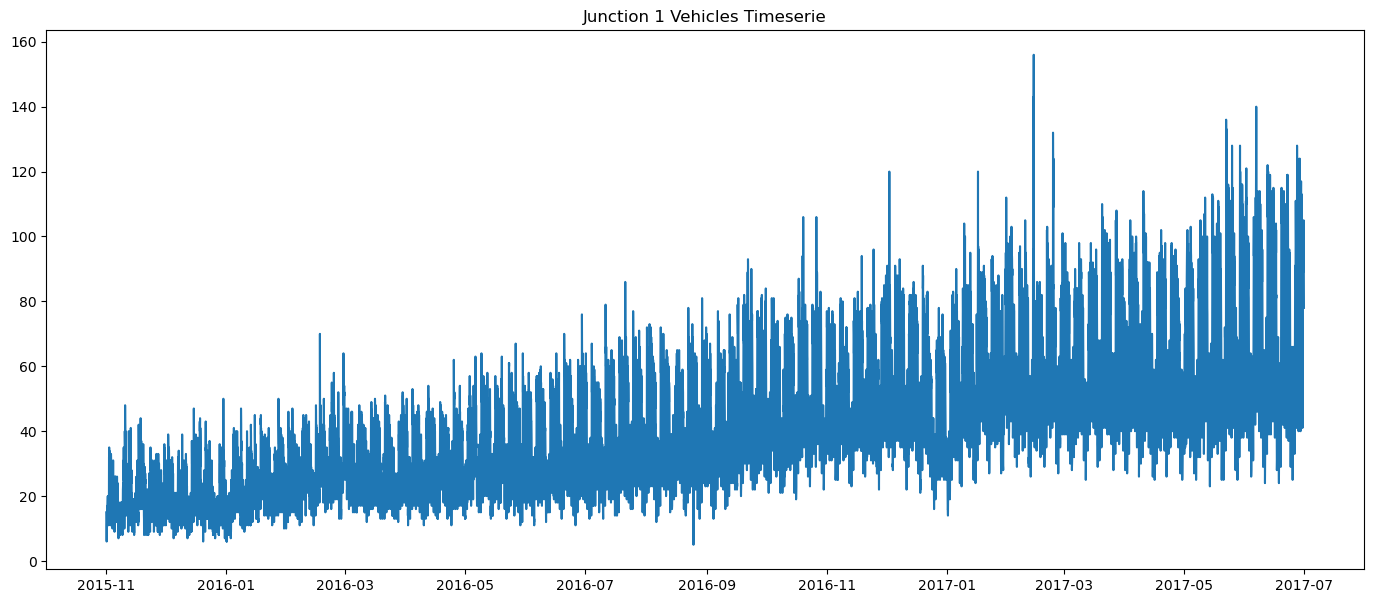

In [13]:
# Graficamos la serie de tiempo 
plt.figure(figsize=(17,7))
plt.plot(timeseries)
plt.title("Junction 1 Vehicles Timeserie")

array([[<AxesSubplot:title={'center':'Vehicles'}>]], dtype=object)

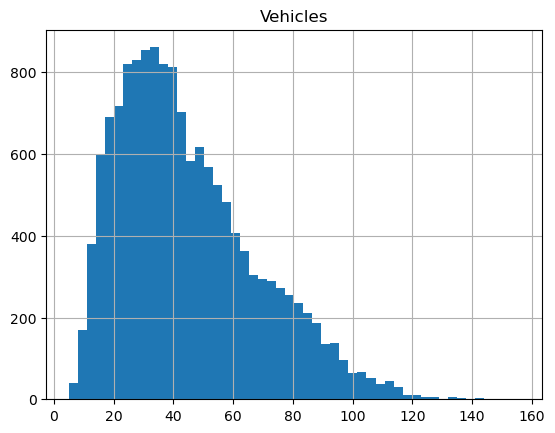

In [14]:
# Histogramas
timeseries.hist(bins=50)

<AxesSubplot:>

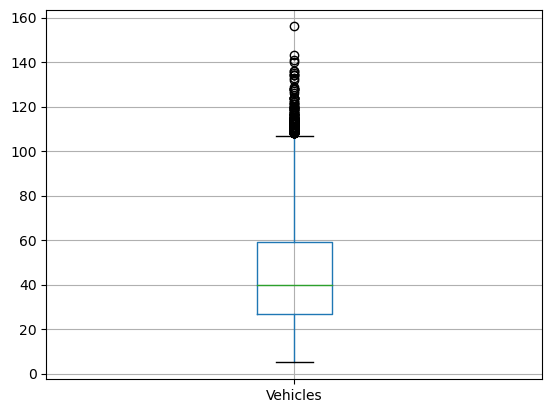

In [15]:
# Distribución de las varibales numéricas
timeseries.boxplot()

Tenemos varios outliers pero no consideramos que haga falta eliminarlas o tratarlas.

In [16]:
# Descripción de las variables numéricas
timeseries.describe()

,Vehicles
count,14592.000000
mean,45.052906
std,23.008345
min,5.000000
25%,27.000000
50%,40.000000
75%,59.000000
max,156.000000


## Modelos lineales

In [17]:
class LinearForecast:
    def __init__(self, data):
        self.data = timeseries

    def adf_test(self):
        print("Results of Dickey-Fuller Test:")
        dftest = adfuller(self.data, autolag="AIC")
        dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Statistic",
                "p-value",
                "#Lags Used",
                "Number of Observations Used",
            ],
        )
        for key, value in dftest[4].items():
            dfoutput["Critical Value (%s)" % key] = value
        print(dfoutput)

        if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
            print("\u001b[32mStationary\u001b[0m")
        else:
            print("\x1b[31mNon-stationary\x1b[0m")

        # Graficar ACF y PACF
    def plot_acf_pacf(self, kwargs=dict()):
        f = plt.figure(figsize=(8,5))

        ax1 = f.add_subplot(121)

        plot_acf(self.data, zero=False, ax=ax1, **kwargs)

        ax2 = f.add_subplot(122)
        plot_pacf(self.data, zero=False, ax=ax2, method='ols', **kwargs)

        plt.show()

    def descomposicion(self):
        data1 = self.data.copy()
        periods_seasonality = (6, 12)

        stl_kwargs = {"seasonal_deg": 0}
        model = MSTL(data1, periods=periods_seasonality, stl_kwargs=stl_kwargs)
        res2 = model.fit()

        # Gráfica de descomposición
        fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 8))

        res2.observed.plot(ax=ax[0])
        ax[0].set_ylabel('Observed')

        res2.trend.plot(ax=ax[1])
        ax[1].set_ylabel('Trend')

        res2.seasonal[f'seasonal_{periods_seasonality[0]}'].plot(ax=ax[2])
        ax[2].set_ylabel(f'seasonal_{periods_seasonality[0]}')

        res2.seasonal[f'seasonal_{periods_seasonality[1]}'].plot(ax=ax[3])
        ax[3].set_ylabel(f'seasonal_{periods_seasonality[1]}')

        res2.resid.plot(ax=ax[4])
        ax[4].set_ylabel('Residual')

        fig.tight_layout()
        
        return res2
        
    def split_dataset(self):
        train_data, test_data = train_test_split(timeseries, test_size=0.25, random_state=0, shuffle=False)

        return train_data, test_data

    def evaluate_forecasts(self,actual, predicted):
            
        mse = mean_squared_error(actual, predicted)
        rmse = mean_squared_error(actual, predicted, squared=True)
        mad = mean_absolute_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)

        return mse, rmse, mad, mape

In [18]:
# Separamos los datos en entrenamiento y prueba (train = 75 y test = 25)
lf = LinearForecast(timeseries)
train, test = lf.split_dataset()

In [19]:
# Mostramos los datos de test
test.head()

,Vehicles
DateTime,
2017-01-30 00:00:00,53
2017-01-30 01:00:00,49
2017-01-30 02:00:00,45
2017-01-30 03:00:00,50
2017-01-30 04:00:00,48


<AxesSubplot:xlabel='DateTime'>

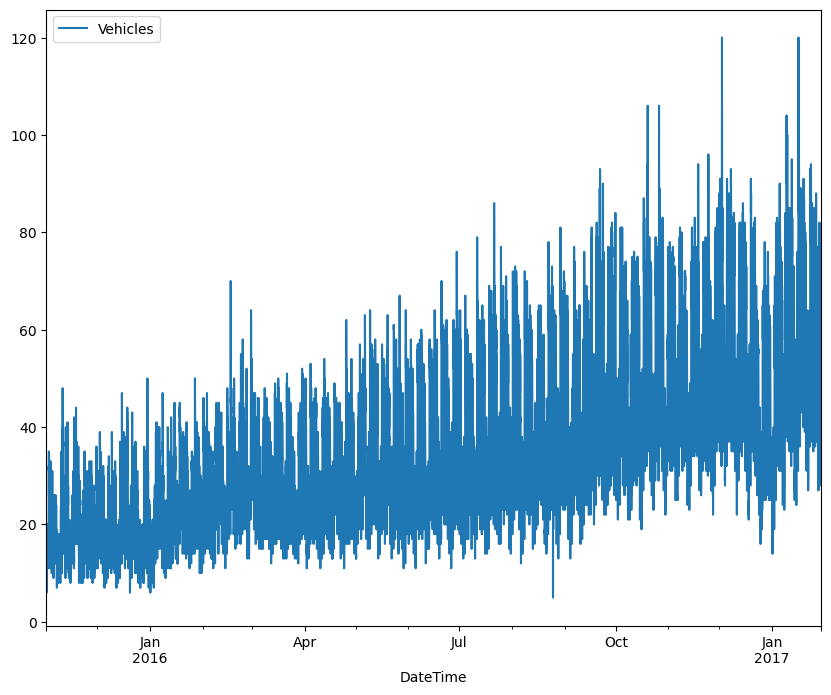

In [20]:
# Graficamos los datos de train 
train.plot(figsize=(10, 8))

In [21]:
#Evaluamos el Sesgo de vehicles
skewness = round(train.skew(),2)
skewness = skewness.to_frame()
skewness = skewness.rename(columns={0: "value"}) 

def f(x):
    if x['value'] < -1 or x['value'] > 1: return 'Highly Skewed'
    elif (x['value']<=0 and x['value']>=-0.5) or (x['value'] >=0 and x['value']<=0.5):
        return 'Symmetric distribution'
    else: return 'Moderately skewed'
    
skewness['skewness'] = skewness.apply(f, axis=1)

skewness

,value,skewness
Vehicles,0.71,Moderately skewed


como estan moderadamente sesgados vamos a hacerle una transformacion de min max scaler

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [23]:
#Transformamos la variable vehic...les2
train["Vehicles2"] = scaler.fit_transform(train)
train

,Vehicles,Vehicles2
DateTime,,
2015-11-01 00:00:00,15,0.086957
2015-11-01 01:00:00,13,0.069565
2015-11-01 02:00:00,10,0.043478
2015-11-01 03:00:00,7,0.017391
2015-11-01 04:00:00,9,0.034783
...,...,...
2017-01-29 19:00:00,58,0.460870
2017-01-29 20:00:00,61,0.486957
2017-01-29 21:00:00,63,0.504348


<AxesSubplot:xlabel='DateTime'>

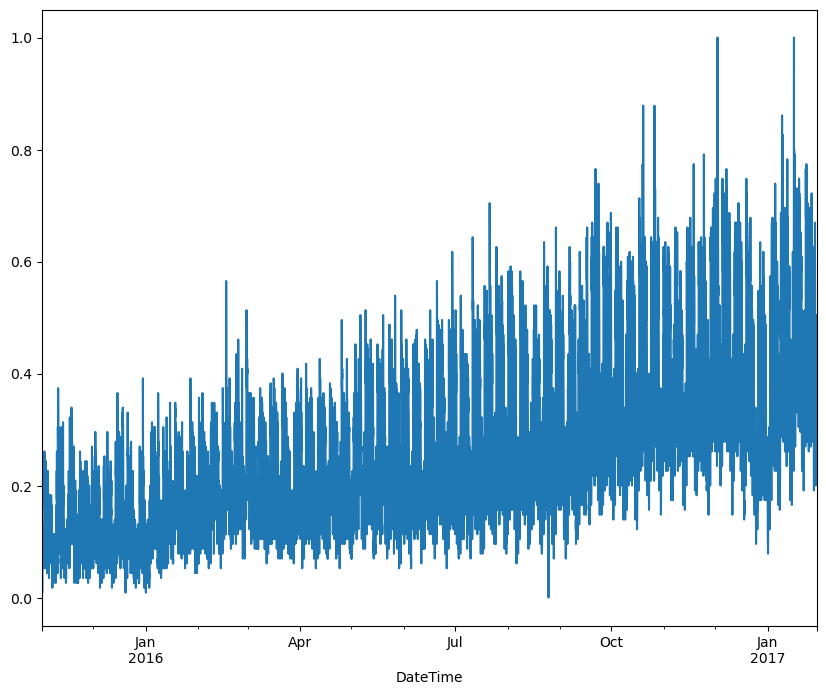

In [24]:
# Mostramos la serie de tiempo de los datos de entrenamiento para ver que le conviene de transformación
train["Vehicles2"].plot(figsize=(10, 8))

C:\Users\Castillejos\AppData\Local\Temp\ipykernel_12532\2149269494.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  train.hist(bins=70, ax=ax[0])


<AxesSubplot:>

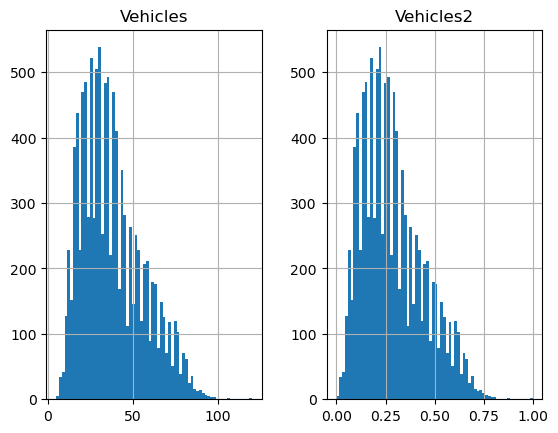

In [25]:
# Realizamos una transformación de log para que se vea mejor la serie de tiempo 
# Obtenemos el histograma para ver los datos. 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2)
train.hist(bins=70, ax=ax[0])
train.boxplot(ax=ax[1])

Decidí hacer un minmaxscaler y para que los datos de prueba tuvieran una distribución de 0 a 1 esto ayuda a que la serie de tiempo no pierda su forma. 

<AxesSubplot:xlabel='DateTime'>

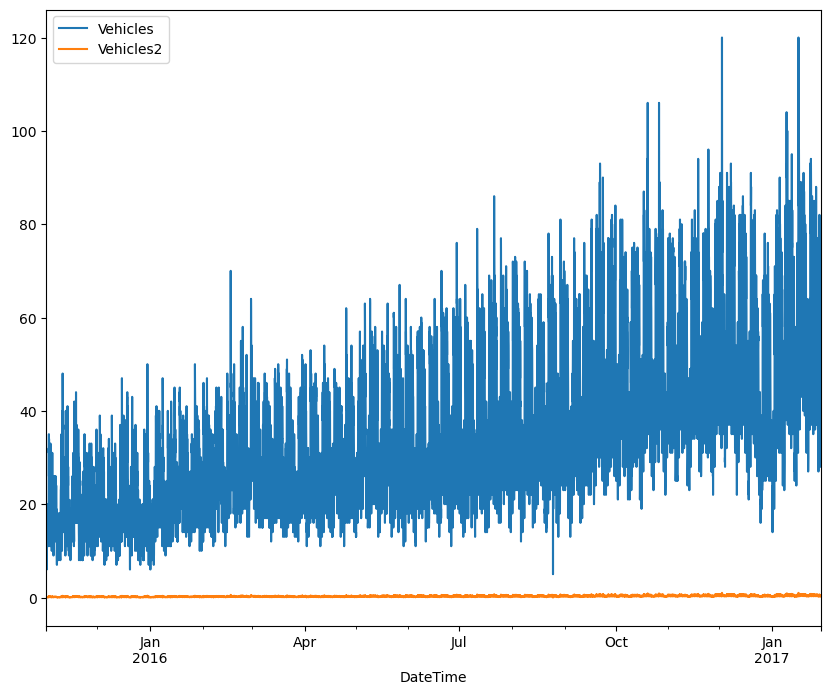

In [26]:
# La serie de tiempo original de train 
train.plot(figsize=(10, 8))

In [27]:
lf = LinearForecast(train["Vehicles2"])
lf.adf_test()

Results of Dickey-Fuller Test:
Test Statistic                -7.148078e+00
p-value                        3.193843e-10
#Lags Used                     4.200000e+01
Number of Observations Used    1.454900e+04
Critical Value (1%)           -3.430800e+00
Critical Value (5%)           -2.861739e+00
Critical Value (10%)          -2.566876e+00
dtype: float64
Stationary


La prueba de Dicker-Fuller nos permite determinar si la serie de tiempo tiene o no estacionariedad. Esta serie de tiempo  tiene estacionariedad lo que significa que la media y la varianza son constantes en el tiempo y no presenta tendencia dentro de la serie

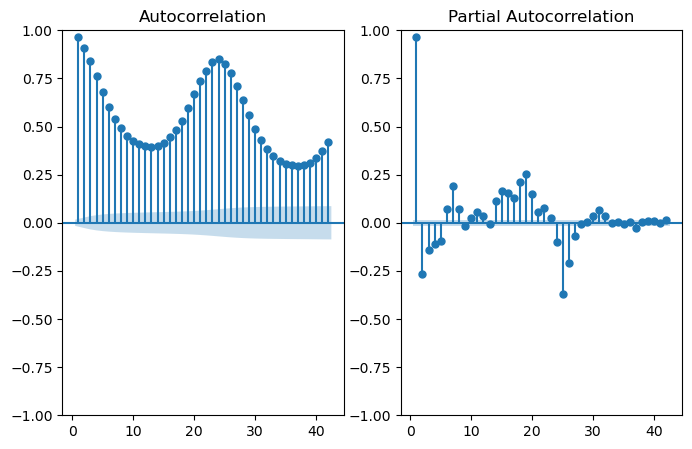

In [28]:
lf.plot_acf_pacf()

Si analizamos las graficas de autocorrelación y autocorrelación parcial la autocorrelacion es positiva pero no tiene una tendencia definida y los valores de autocorrelación significantes no son representativos para la muestra.Se puede considerar realizar transformaciones de la serie de tiempo para mejorar. 

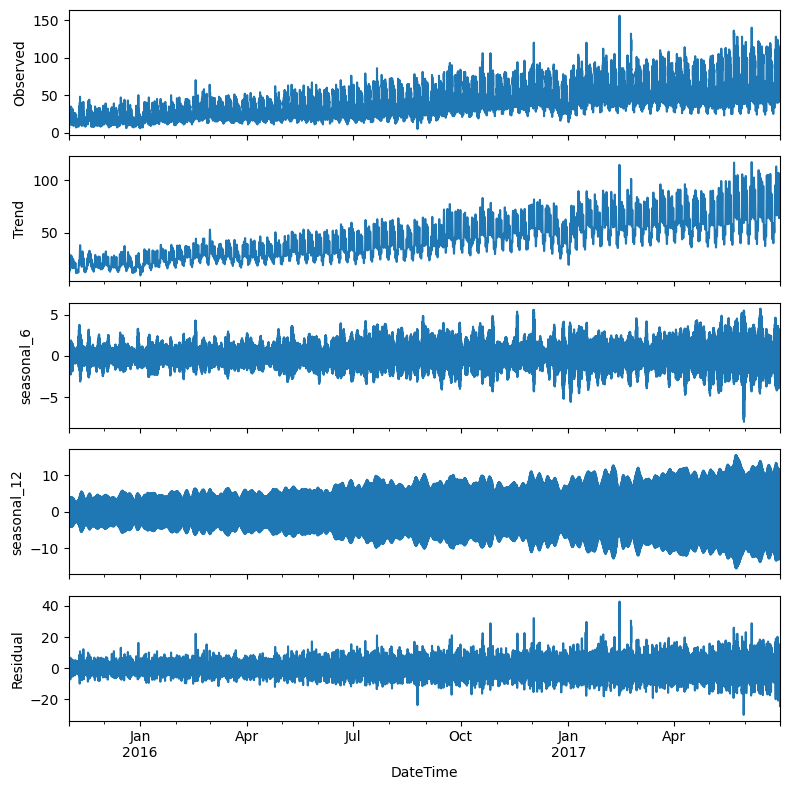

In [29]:
#Vemos la descomposición de los datos
des = lf.descomposicion()

Este gráfico de descomposion nos ayuda a entender mejor la serie de tiempo y analizarla con más entendimiento. Cuando analizamos la serie de tiempo tomada a 12 meses podemos ver que cumple con un ciclo repetitivo por lo tanto podriamos inferir que si tiene estacionalidad.

In [30]:
seasonality_6 = des.seasonal['seasonal_6']
LinearForecast(seasonality_6).adf_test()

Results of Dickey-Fuller Test:
Test Statistic                -7.148078e+00
p-value                        3.193843e-10
#Lags Used                     4.200000e+01
Number of Observations Used    1.454900e+04
Critical Value (1%)           -3.430800e+00
Critical Value (5%)           -2.861739e+00
Critical Value (10%)          -2.566876e+00
dtype: float64
Stationary


In [31]:
seasonality_12 = des.seasonal['seasonal_12']
LinearForecast(seasonality_12).adf_test()

Results of Dickey-Fuller Test:
Test Statistic                -7.148078e+00
p-value                        3.193843e-10
#Lags Used                     4.200000e+01
Number of Observations Used    1.454900e+04
Critical Value (1%)           -3.430800e+00
Critical Value (5%)           -2.861739e+00
Critical Value (10%)          -2.566876e+00
dtype: float64
Stationary


> **Conclusión** Como el nivel de significacia es de 3.19, se puede rechazar la hipótesis nula. Por lo tanto, la serie es estacionaria en ambos casos.

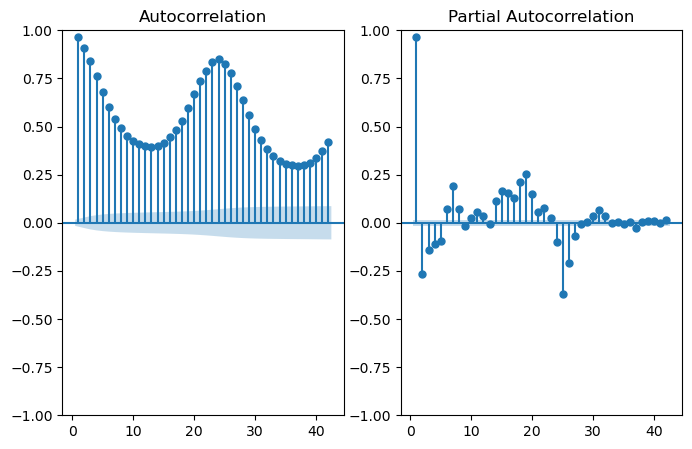

In [32]:
# Sacamos 
lf12 = LinearForecast(seasonality_12)
lf12.plot_acf_pacf()

Los parámetros que evaluo dentro de la serie de tiempo son: 
 * p = 0 - 5
 * d = 0
 * q = 0 - 2 
 
 * P = 0 - 1
 * D = 0 
 * Q = 0 - 1

In [33]:
import itertools

# Posibles valores en lo que pueden variar los parámetros de un SARIMAX
# Parte no estacional
p = [0, 1, 2, 3, 4, 5]
d = [0]
q = [0, 1, 2]
# Parte estacional
P = [0, 1]
D = [0]
Q = [0, 1]
# Tipo de tendencia
t = ['n', 'c', 't', 'ct']

#sarimax_params
param_no_estacionales = list(itertools.product(p, d, q))
param_estacionales = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]
sarimax_params = list(itertools.product(param_no_estacionales, param_estacionales, t))
sarimax_params

[((0, 0, 0), (0, 0, 0, 12), 'n'),
 ((0, 0, 0), (0, 0, 0, 12), 'c'),
 ((0, 0, 0), (0, 0, 0, 12), 't'),
 ((0, 0, 0), (0, 0, 0, 12), 'ct'),
 ((0, 0, 0), (0, 0, 1, 12), 'n'),
 ((0, 0, 0), (0, 0, 1, 12), 'c'),
 ((0, 0, 0), (0, 0, 1, 12), 't'),
 ((0, 0, 0), (0, 0, 1, 12), 'ct'),
 ((0, 0, 0), (1, 0, 0, 12), 'n'),
 ((0, 0, 0), (1, 0, 0, 12), 'c'),
 ((0, 0, 0), (1, 0, 0, 12), 't'),
 ((0, 0, 0), (1, 0, 0, 12), 'ct'),
 ((0, 0, 0), (1, 0, 1, 12), 'n'),
 ((0, 0, 0), (1, 0, 1, 12), 'c'),
 ((0, 0, 0), (1, 0, 1, 12), 't'),
 ((0, 0, 0), (1, 0, 1, 12), 'ct'),
 ((0, 0, 1), (0, 0, 0, 12), 'n'),
 ((0, 0, 1), (0, 0, 0, 12), 'c'),
 ((0, 0, 1), (0, 0, 0, 12), 't'),
 ((0, 0, 1), (0, 0, 0, 12), 'ct'),
 ((0, 0, 1), (0, 0, 1, 12), 'n'),
 ((0, 0, 1), (0, 0, 1, 12), 'c'),
 ((0, 0, 1), (0, 0, 1, 12), 't'),
 ((0, 0, 1), (0, 0, 1, 12), 'ct'),
 ((0, 0, 1), (1, 0, 0, 12), 'n'),
 ((0, 0, 1), (1, 0, 0, 12), 'c'),
 ((0, 0, 1), (1, 0, 0, 12), 't'),
 ((0, 0, 1), (1, 0, 0, 12), 'ct'),
 ((0, 0, 1), (1, 0, 1, 12), 'n'),
 ((0, 0

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
n = 5
resultados = pd.DataFrame(columns=['params', 'AIC', 'BIC', 'LLF'], index=np.arange(0, 11))

i = 0
for par_no_esta, par_esta, trend in sarimax_params:
    mod = SARIMAX(
        endog=seasonality_12,
        trend=trend,
        order=par_no_esta,
        seasonal_order=par_esta
    )
    results = mod.fit(disp=False)

    resultados.loc[i, 'params'] = str((par_no_esta, par_esta, trend))
    resultados.loc[i, 'AIC'] = results.aic
    resultados.loc[i, 'BIC'] = results.bic
    resultados.loc[i, 'LLF'] = results.llf
    i += 1

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\b

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\b

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packag

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packag

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\b

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packag

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\b

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\b

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packag

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packag

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packag

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packag

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packag

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packag

In [35]:
resultados.sort_values(by=['AIC'], ascending=True)

,params,AIC,BIC,LLF
284,"((5, 0, 2), (1, 0, 1, 12), 'n')",-24095.593651,-24019.711364,12057.796826
285,"((5, 0, 2), (1, 0, 1, 12), 'c')",-23995.423231,-23911.952715,12008.711615
268,"((5, 0, 1), (1, 0, 1, 12), 'n')",-22173.261425,-22104.967366,11095.630712
236,"((4, 0, 2), (1, 0, 1, 12), 'n')",-21506.198318,-21437.90426,10762.099159
269,"((5, 0, 1), (1, 0, 1, 12), 'c')",-21131.856185,-21055.973898,10575.928092
...,...,...,...,...
131,"((2, 0, 2), (0, 0, 0, 12), 'ct')",876751.296819,876804.41442,-438368.648409
134,"((2, 0, 2), (0, 0, 1, 12), 't')",876751.319393,876804.436994,-438368.659697
135,"((2, 0, 2), (0, 0, 1, 12), 'ct')",876753.296105,876814.001935,-438368.648053
178,"((3, 0, 2), (0, 0, 0, 12), 't')",1074380.850398,1074433.967998,-537183.425199


Los mejores 5 modelos son:

    *  (5, 0, 2), (1, 0, 1, 12) 'n'
    *  (5, 0, 2), (1, 0, 1, 12) 'c'
    *  (5, 0, 1), (1, 0, 1, 12), 'n'
    *  (4, 0, 2), (1, 0, 1, 12), 'n'
    *  (5, 0, 1), (1, 0, 1, 12), 'c'

In [37]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(train["Vehicles2"],order=(5, 0, 2),seasonal_order=(1,0,1,12))
results=model.fit()

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\

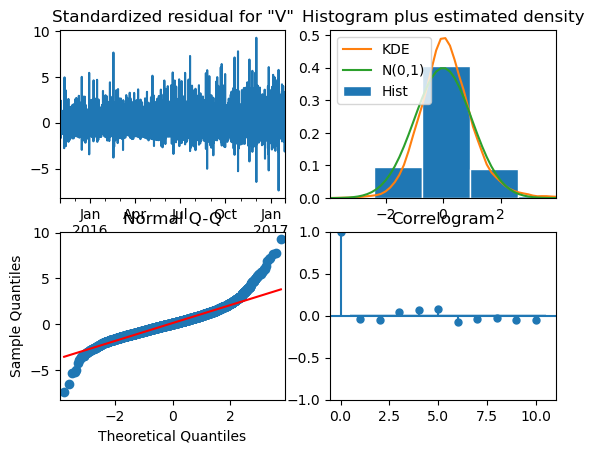

In [38]:
#Gráfico de los diagnósticos para los residuos
results.plot_diagnostics();

Los residuos parecen ser normales por que la distribución se parece a la normal, por la gráfica del correlogram se puede ver que los residuos no estan correlacionados lo cual indica que el modelo es bueno.

In [39]:
test["AvgTemperature2"] = scaler.transform(test)
test.head()

,Vehicles,AvgTemperature2
DateTime,,
2017-01-30 00:00:00,53,0.417391
2017-01-30 01:00:00,49,0.382609
2017-01-30 02:00:00,45,0.347826
2017-01-30 03:00:00,50,0.391304
2017-01-30 04:00:00,48,0.373913


In [ ]:
model2=sm.tsa.statespace.SARIMAX(train["AvgTemperature2"],order=(4, 0, 2),seasonal_order=(1,0,1,12))
results2=model2.fit()

## Modelos no lineales

#### MLP

In [ ]:
# dividir una secuencia univariada en muestras
def split_univariate_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps

        # comprobar si estamos más allá de la secuencia
        if end_ix > len(sequence)-1:
            break
        # reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
plt.plot(vals_bc)

In [ ]:
# Elegir un número de pasos de tiempo
n_steps = 3
# Dividir en muestras
X, y = split_univariate_sequence(vals_bc, n_steps)

print('X', X, 'y', y, sep='\n')

In [ ]:
# Definimos el modelo
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
def split_dataset(X, y):
    """
    Función que se encarga de dividir la data ingresada en datos de entrenamiento, validación y prueba.
    :param data: Data con la información de la serie de tiempo a analizar.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(X, y)
print("X_train shape:", X_train.shape, "\ny_train shape:",y_train.shape,"\nX_val shape: ", X_val.shape, "\ny_val shape:", y_val.shape, "\nX_test shape:",X_test.shape, "\ny_test shape:",y_test.shape)

In [ ]:
def modelo2(n_steps, X_train, y_train, X_val, y_val, X_test, y_test):
    model = keras.models.Sequential([
        keras.layers.Input(n_steps),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1)
    ])

    # Compilar el modelo y definir métricas y funciones de pérdida
    model.compile(optimizer='adam', loss='mape', metrics="mse")

    # Resumir el modelo compilado
    model.summary()

    history1 = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, verbose=False)

    # Analizar función de pérdida
    plt.plot(history1.history['loss'], 'r--', label='loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    # Analizar las métricas
    plt.plot(history1.history['mse'], 'r--', label='loss')
    plt.xlabel('epochs')
    plt.ylabel('mse')
    plt.legend()
    plt.show()

    # Evaluar el modelo en el conjunto de prueba
    test_mape_score, test_mse_score = model.evaluate(X_test, y_test)
    return test_mape_score, test_mse_score


In [ ]:
test_mape_score, test_mse_score = modelo2(n_steps, X_train, y_train, X_val, y_val, X_test, y_test)
print('MAPE en el conjunto de prueba:', test_mape_score)
print('MSE en el conjunto de prueba:', test_mse_score)

#### CNN

In [ ]:
# Definir la secuencia de entrada
raw_seq = vals_bc.tolist()
# Elegir un número de pasos de tiempo
n_steps = 3
# Número de características de mis datos
n_features = 1
# Dividir en muestras
X, y = split_univariate_sequence(raw_seq, n_steps)

print('X', X, 'y', y, sep='\n')

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D

In [ ]:
def modelo_cnn(n_steps, X_train, y_train, X_val, y_val, X_test, y_test):

    # Definimos el modelo
    model_1 = Sequential()
    model_1.add(Conv1D(64, 2, activation='relu', input_shape=(n_steps, n_features)))
    model_1.add(Dense(32, activation='relu'))
    model_1.add(MaxPooling1D())
    model_1.add(Flatten())
    model_1.add(Dense(1))

    model_1.summary()

    # Compilar el modelo y definir métricas y funciones de pérdida
    model_1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mape', metrics=['mse'])

    h = model_1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, verbose=False)

    # Analizar función de pérdida
    plt.plot(h.history['loss'], 'r--', label='loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    # Analizar las métricas
    plt.plot(h.history['mse'], 'r--', label='loss')
    plt.xlabel('epochs')
    plt.ylabel('mse')
    plt.legend()
    plt.show()

    # Evaluar el modelo en el conjunto de prueba
    test_mape_score, test_mse_score = model_1.evaluate(X_test, y_test)
    return test_mape_score, test_mse_score


In [ ]:
cnn_test_mape_score1, cnn_test_mse_score1 = modelo_cnn(n_steps, X_train, y_train, X_val, y_val, X_test, y_test)
print('MAPE en el conjunto de prueba:', cnn_test_mape_score1)
print('MSE en el conjunto de prueba:', cnn_test_mse_score1)

#### LSTM

In [ ]:
LSTM_earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=15)